# Task 2

## Manual Ground Truth 
We pick the first question that contains a bug (Question.ID = 1) and all correct explanations to manually formulate a ground truth.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../data/answerList_data.csv')

df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | (
            (df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df_correct_question1 = df[(df['correctness'] == 1) & (df['Question.ID'] == 1)]
explanations = df_correct_question1['Answer.explanation']
for t in explanations:    
    print(t)


Minutes are set to -15; which is less then 0 and it throws illegal arg exception
In the code there is a check that 0 <= minutes < 60 and the minutesOffset is -15 which does not fall into these prarmeters thus throwing an Exception
There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)
YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (minutesOffset < -59 || minutesOffset > 59) {" because now the method can take in the number of minutes as a negative and will allow the method to properly progress to invoke/call further methods such as those asked about in the two previous questions.
The variable "minutesOffset" is checked incorrectly b

Our manual ground truth is:

In [3]:
groundTruth = "The IF statement in line 279 checks whether minutesOffset is set to a value between 0 and 59. If not, an IllegalArgumentException is thrown. This is a bug because the minutesOffset may also be negative. The IF statement should check for the minutesOffset to be between -59 and 59."

---
Now we choose metrics to evaluate readability and semantic similarity between the manual ground truth and the explanations generated by the LLM.

## Readability

### Flesch Reading Ease and Automated Readability Index
We choose the Flesch Reading Ease metric and Automated Readability Index, as they are well-known readability metrics that are easy to compute and simple to interpret. The Flesch Reading Ease gives a score between 0 and 100, where a score between 60 and 80 is considered easy to read. The Automated Readability Index gives a score between 1 and 14, where for most readers an ideal score is between 7 and 9.


## Semantic Similarity

### BLEU
We selected BLEU because of its simplicity and our prior experience with it from the previous miniproject. BLEU is widely recognized as a standard metric for measuring semantic similarity and requires minimal computational effort. As the explanations and our ground truth are both short texts, we change the BLEU weights to not incorporate 3-grams and 4-grams.

### Cosine Similarity of Embeddings
A disadvantage of BLEU is that it does not consider the semantic meaning of the explanations. Therefore, we also compute the cosine similarity of the embeddings of the explanations and the ground truth. 

# Expectations and Setting a Threshold

It is hard for us to come up with a good threshold for the metrics before seeing the results for our data, as we do not really know what ranges of numbers to expect. 

If the summarized explanations get better, we would expect the readability metrics to get worse, as the summaries become more technical and precise. The similarity to the ground truth should increase because the ground truth contains information from multiple explanations, so you need more explanations to cover all the information. 

Maybe a good threshold could be a cosine similarity of 0.75.

In [46]:
import nltk

def calculate_bleu(hyp, ref):
    hypothesis = hyp.split()
    reference = ref.split()
    return nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights=(0.5, 0.5, 0, 0))

In [5]:

from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_cosine_similarity(hyp, ref):
    hyp_embedding = model.encode(hyp)
    ref_embedding = model.encode(ref)
    return np.dot(hyp_embedding, ref_embedding) / (np.linalg.norm(hyp_embedding) * np.linalg.norm(ref_embedding))



In [6]:
import textstat
def calculate_flesch_reading_ease(text):
    return textstat.flesch_reading_ease(text)

def calculate_automated_readability_index(text):
    return textstat.automated_readability_index(text)


# Run the experiments

In [7]:
# We use the prompt that performed better in our last mini project
def get_prompt_2(explanations):
        return f"""
Please summarize these reports of the same bug. 
Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. 
Summarize the report of the bug concisely. Keep the summary as short as possible.

These are the reports:

{explanations}

"""

In [8]:
from openai import OpenAI
client = OpenAI(
    api_key=""
)

def query_llm(explanations):
    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": get_prompt_2(str(explanations)),
        }
    ],
    model="gpt-4o-mini",
    )

    return chat_completion.choices[0].message.content

In [10]:

import matplotlib.pyplot as plt
def sample_explanations(explanations, n):
    return explanations.sample(n)

# plot metric scores
def plot_metric_scores(metric_scores):
    plt.plot(metric_scores)
    plt.show()

    

In [60]:

# Create lists to store the data
input_explanations_list = []
llm_summaries_list = []
num_explanations_list = []

# Modify the experiment loop to store the data
for i in range(1, len(df_correct_question1['Answer.explanation'])):
    # sample 3 times and take average
    for k in range(3):
        explanations = sample_explanations(df_correct_question1['Answer.explanation'], i)
        llm_summary = query_llm(explanations)
        
        # Store the data
        input_explanations_list.append(str(explanations.values))
        llm_summaries_list.append(llm_summary)
        num_explanations_list.append(i)

# Create a DataFrame with the collected data
results_df = pd.DataFrame({
    'num_explanations': num_explanations_list,
    'input_explanations': input_explanations_list,
    'llm_summary': llm_summaries_list,
    'flesch_reading_ease': [calculate_flesch_reading_ease(summary) for summary in llm_summaries_list],
    'automated_readability_index': [calculate_automated_readability_index(summary) for summary in llm_summaries_list],
    'bleu_score': [calculate_bleu(summary, groundTruth) for summary in llm_summaries_list],
    'cosine_similarity': [calculate_cosine_similarity(summary, groundTruth) for summary in llm_summaries_list]
})

# Save the DataFrame to CSV
results_df.to_csv('llm_summarization_results.csv', index=False)


/Users/hendrik/Documents/HPI/MA5/AI4SE Lecture/miniproject1/ASE-GenAI/.venv/lib/python3.13/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/hendrik/Documents/HPI/MA5/AI4SE Lecture/miniproject1/ASE-GenAI/.venv/lib/python3.13/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/hendrik/Documents/HPI/MA5/AI4SE Lecture/miniproject1/ASE-GenAI/.venv/lib/python3.13/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram over


We can see a clear trend that the readability metrics change the more explanations are merged. The Flesch Reading Ease decreases, which means the explanations become harder to read, most likely because they get more technical and precise. The Automated Readability Index shows the same trend, but here, higher numbers mean the text is harder to read. 

The BLEU score, even if very low, increases with the number of explanations. Just as the increasing cosine similarity, it shows that the generated summary gets more similar to the ground truth with more explanations merged.

Taking our threshold of a cosine similarity of 0.75 into account, we would have to incorporate all explanations.

Looking at the data, the first significant improvement in all metrics but the Flesch Reading Ease happens for 3 explanations, which could be good number if we want to keep the number of explanations low but still get a good summary.

As both the readability and the semantic similarity metrics improve with more explanations, we should definitely use the summarization in our pipeline.

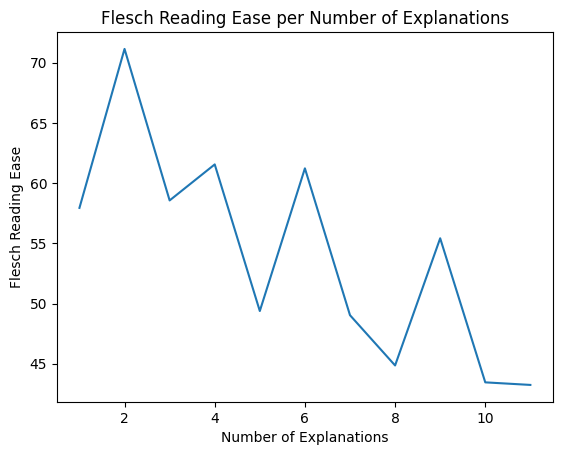

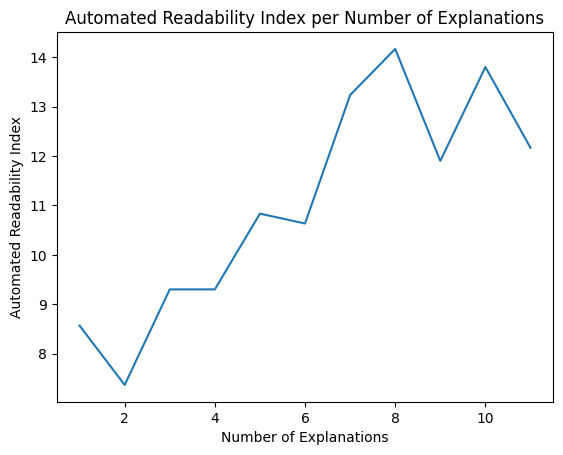

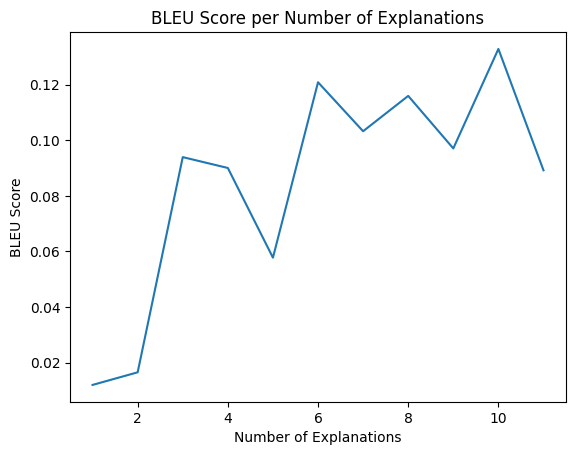

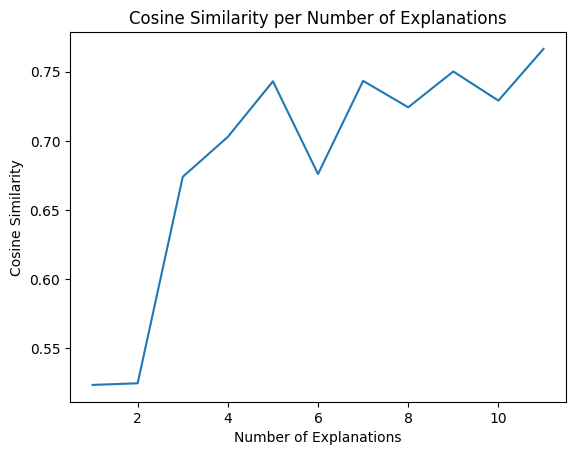

In [61]:

plt.plot(results_df['flesch_reading_ease'].groupby(results_df['num_explanations']).mean())
plt.xlabel('Number of Explanations')
plt.ylabel('Flesch Reading Ease')
plt.title('Flesch Reading Ease per Number of Explanations')
plt.show()

plt.plot(results_df['automated_readability_index'].groupby(results_df['num_explanations']).mean())
plt.xlabel('Number of Explanations')
plt.ylabel('Automated Readability Index')
plt.title('Automated Readability Index per Number of Explanations')
plt.show()

plt.plot(results_df['bleu_score'].groupby(results_df['num_explanations']).mean())
plt.xlabel('Number of Explanations')
plt.ylabel('BLEU Score')
plt.title('BLEU Score per Number of Explanations')
plt.show()

plt.plot(results_df['cosine_similarity'].groupby(results_df['num_explanations']).mean())
plt.xlabel('Number of Explanations')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity per Number of Explanations')
plt.show()